import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# veritable buffet for marine microbes

In [2]:
auth = earthaccess.login()

In [3]:
tspan = ("2025-01-07", "2025-01-30")
bbox = (-131.9569, 29.4430, -100.8539, 37.9144) # west, south, east, north


In [4]:
# results_land = earthaccess.search_data(
#     short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
#     temporal=tspan,
#     bounding_box=bbox
# )
# len(results_land)

# results_oean = earthaccess.search_data(
#     short_name="PACE_SPEXONE_L2_AER_RTAPOCEAN",
#     temporal=tspan,
#     bounding_box=bbox
# )
# len(results_oean)

results_L3 = earthaccess.search_data(
    short_name="PACE_SPEXONE_L3M_AER_RTAP",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*0p1deg*",  # Daily only for MOANA | Resolution: 0p1deg or 4 (for 4km)

)
len(results_L3)


12

In [5]:
# paths_land = earthaccess.open(results_land)
# paths_ocean = earthaccess.open(results_oean)
path_spex=earthaccess.open(results_L3)

QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

In [6]:

def time_from_attr(ds):
    """Set the time attribute as a dataset variable
    Args:
        ds: a dataset corresponding to one or multiple Level-2 granules
    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["date"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("date")
    return ds



# for i in range(
    
# datatree = xr.open_datatree(paths_ocean[0])
# dataset = xr.merge(datatree.to_dict().values())


# # data = xr.open_mfdataset(paths_land,concat_dim='time',combine='nested')
# # dataset = xr.merge(data.to_dict().values())
# xr.open_mfdataset(paths,
#     combine="nested",
#     concat_dim="date"
# )


In [7]:
dataset_spex = xr.open_mfdataset(path_spex, combine="nested",preprocess=preprocess, concat_dim="date")
ds_subset = dataset_spex.sel(
    lon=slice(bbox[0], bbox[2]),
    lat=slice(bbox[3], bbox[1])  # note: lat is usually north→south, so reverse order
)

ssa_data=ds_subset["ssa"].mean('date').sel(wavelength='550')

NameError: name 'preprocess' is not defined

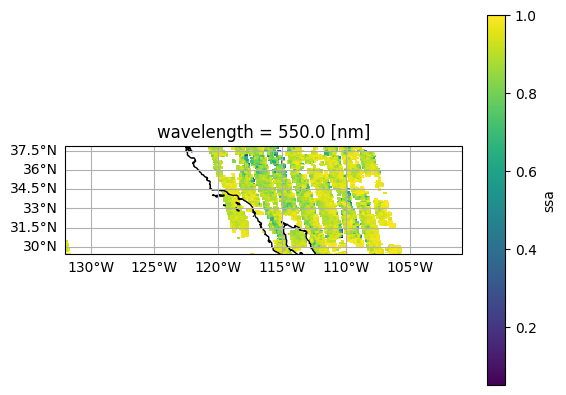

In [34]:

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = ssa_data.plot( cmap="viridis",  ax=ax
)

In [9]:
from pathlib import Path

import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from glob import glob
from datetime import datetime
import pdb

target_date = datetime(2025,1,5)
oci_dir = '/home/jovyan/shared-public/FirePhytos_DustBlumes/PACE_OCI_AOD/*'
files = sorted(glob(oci_dir + target_date.strftime('*%Y%m*')))
#files = sorted(glob(oci_dir))
print(len(files))
# pdb.set_trace()
#dataset_spex = xr.open_mfdataset(files, combine="nested",preprocess=time_from_attr, concat_dim="date")

aods = []
ssas = []
lons = []
lats = []
ssas_dt=[]
AIs=[]
for file in files:

    datatree = xr.open_datatree(file)
    dataset = xr.merge(datatree.to_dict().values())
    
    lon = np.array(dataset['longitude'])
    lat = np.array(dataset['latitude'])
    aod = np.squeeze(np.array(dataset['Aerosol_Optical_Depth'][:,:,3]))
    # fmf = np.squeeze(np.array(dataset['Aerosol_Optical_Depth'][:,:,3]))
    ssa_388_dt = np.squeeze(np.array(dataset['DT_AerosolSingleScattAlbedo'][:,:,2]))
    ssa_388_nuv = np.squeeze(np.array(dataset['NUV_AerosolSingleScattAlbedo'][:,:,3]))
    AI = np.squeeze(np.array(dataset['NUV_AerosolIndex']))

    
    lons.append(lon)
    lats.append(lat)
    aods.append(aod)
    ssas.append(ssa_388_nuv)
    ssas_dt.append(ssa_388_dt)
    AIs.append(AI)

# aods=np.nanmean(aods,axis=0)    
# ssas=np.nanmean(ssas,axis=0)    
# lons=np.nanmean(lons,axis=0)    
# lats=np.nanmean(lats,axis=0)    

    

170


In [10]:
import matplotlib.colors as mcolors
import copy

def plot_l2_product(
    lon, lat, data, plot_range, label, title, vmin, vmax, figsize=(12, 4), cmap="jet", mask_black=False):

    # --- If masking for black ---
    if mask_black:
        cmap_orig = plt.get_cmap(cmap)
        cmap_mod = copy.copy(cmap_orig)
        cmap_mod.set_over('black')  # values above vmax will be black
    else:
       #cmap_mod = cmap
        cmap_orig = plt.get_cmap(cmap)
        cmap_mod = copy.copy(cmap_orig)
        cmap_mod.set_over('red')  # values above vmax will be black

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.3)

    ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    ax_map.set_extent(plot_range, crs=ccrs.PlateCarree())
    ax_map.coastlines(resolution="110m", color="black", linewidth=1)
    ax_map.gridlines(draw_labels=True)
    ax_map.set_title(title, fontsize=12)

    for i in range(len(data)):
        pm = ax_map.pcolormesh(
            lon[i], lat[i], data[i],
            vmin=vmin, vmax=vmax, cmap=cmap_mod,
            transform=ccrs.PlateCarree()
        )

    plt.colorbar(pm, ax=ax_map, orientation="vertical", pad=0.1, label=label)

    # --- Add major city names ---
    cities = {
        "San Francisco": (-122.4194, 37.7749),
        "Los Angeles": (-118.2437, 34.0522),
        "San Diego": (-117.1611, 32.7157),
    }
    for city, (lon_c, lat_c) in cities.items():
        ax_map.text(lon_c, lat_c, city,
                    transform=ccrs.PlateCarree(),
                    fontsize=10, fontweight='bold',
                    color='black',
                    ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2'))

    plt.tight_layout()
    plt.show()

import matplotlib.colors as mcolors
import copy

def plot_l2_product_ssa(
    lon, lat, data, plot_range, label, title, vmin, vmax, figsize=(12, 4), cmap="jet", mask_black=False):

    # --- If masking for black ---
    if mask_black:
        cmap_orig = plt.get_cmap(cmap)
        cmap_mod = copy.copy(cmap_orig)
        cmap_mod.set_over('black')  # values above vmax will be black
    else:
       #cmap_mod = cmap
        cmap_orig = plt.get_cmap(cmap)
        cmap_mod = copy.copy(cmap_orig)
        cmap_mod.set_over('red')  # values above vmax will be black

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.3)

    ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    ax_map.set_extent(plot_range, crs=ccrs.PlateCarree())
    ax_map.coastlines(resolution="110m", color="black", linewidth=1)
    ax_map.gridlines(draw_labels=True)
    ax_map.set_title(title, fontsize=12)

    for i in range(len(data)):
        pm = ax_map.pcolormesh(
            lon[i], lat[i], data[i],
            vmin=vmin, vmax=vmax, cmap=cmap_mod,
            transform=ccrs.PlateCarree()
        )

    plt.colorbar(pm, ax=ax_map, orientation="vertical", pad=0.1, label=label)

    # --- Add major city names ---
    cities = {
        "San Francisco": (-122.4194, 37.7749),
        "Los Angeles": (-118.2437, 34.0522),
        "San Diego": (-117.1611, 32.7157),
    }
    for city, (lon_c, lat_c) in cities.items():
        ax_map.text(lon_c, lat_c, city,
                    transform=ccrs.PlateCarree(),
                    fontsize=10, fontweight='bold',
                    color='black',
                    ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2'))

    plt.tight_layout()
    plt.show
    #plt.savefig('', dpi=300, bbox_inches='tight')


/tmp/ipykernel_146/1126569404.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


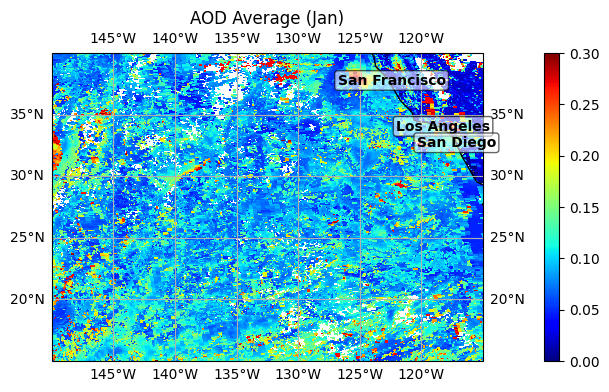

/tmp/ipykernel_146/1126569404.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


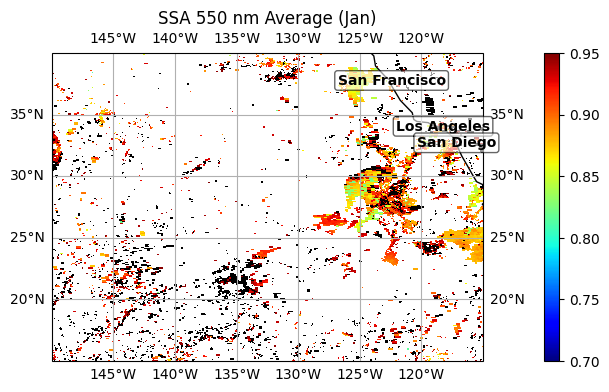

/tmp/ipykernel_146/1126569404.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


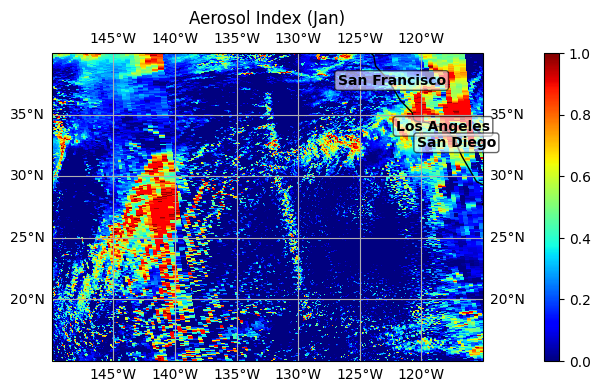

/tmp/ipykernel_146/1126569404.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


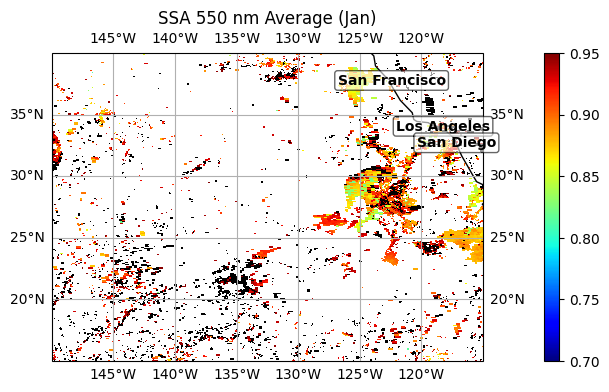

In [11]:
plot_range=[np.float32(-115), # east
 np.float32(-150), # west
 np.float32(15), # south
 np.float32(40)] # north

plot_l2_product(lons, lats,
aods, plot_range=plot_range, label='', title="AOD Average (Jan)", vmin=0, vmax=0.3, 
                 cmap="jet")

# plot_l2_product(lon, lat,
# ssa_388_dt, plot_range=plot_range, label='', title='DT_SSA', vmin=0.7, vmax=1, 
#                 fn=target_date.strftime('PACE_OCI_DTSSA_%Y%m%d.png'), cmap="jet")

plot_l2_product(
    lons, lats, ssas,
    plot_range=plot_range,
    label='', title='SSA 550 nm Average (Jan)',
    vmin=0.7, vmax=0.95, cmap="jet",  # vmax set to 0.95
    mask_black=True
)

plot_l2_product(lons, lats,
AIs, plot_range=plot_range, label='', title='Aerosol Index (Jan)', vmin=0, vmax=1, 
                cmap="jet")


plot_l2_product_ssa(
    lons, lats, ssas,
    plot_range=plot_range,
    label='', title='SSA 550 nm Average (Jan)',
    vmin=0.7, vmax=0.95, cmap="jet",  # vmax set to 0.95
    mask_black=True
)


In [12]:
from pathlib import Path

import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from glob import glob
from datetime import datetime
import pdb

target_date = datetime(2024,12,5)

oci_dir = '/home/jovyan/shared-public/FirePhytos_DustBlumes/PACE_OCI_AOD/*'
files = sorted(glob(oci_dir + target_date.strftime('*%Y%m*')))
#files = sorted(glob(oci_dir))
print(len(files))
# pdb.set_trace()
#dataset_spex = xr.open_mfdataset(files, combine="nested",preprocess=time_from_attr, concat_dim="date")

ssas_dt_Dec=[]
aods_Dec = []
ssas_Dec = []
lons_Dec = []
lats_Dec = []
AIs_Dec=[]
for file in files:

    datatree = xr.open_datatree(file)
    dataset = xr.merge(datatree.to_dict().values())
    lon = np.array(dataset['longitude'])
    lat = np.array(dataset['latitude'])
    aod = np.squeeze(np.array(dataset['Aerosol_Optical_Depth'][:,:,3]))
    # fmf = np.squeeze(np.array(dataset['Aerosol_Optical_Depth'][:,:,3]))
    ssa_388_dt = np.squeeze(np.array(dataset['DT_AerosolSingleScattAlbedo'][:,:,2]))
    ssa_388_nuv = np.squeeze(np.array(dataset['NUV_AerosolSingleScattAlbedo'][:,:,3]))
    AI = np.squeeze(np.array(dataset['NUV_AerosolIndex']))

    lons_Dec.append(lon)
    lats_Dec.append(lat)
    aods_Dec.append(aod)
    ssas_Dec.append(ssa_388_nuv)
    ssas_dt_Dec.append(ssa_388_dt)
    AIs_Dec.append(AI)
# aods=np.nanmean(aods,axis=0)    
# ssas=np.nanmean(ssas,axis=0)    
# lons=np.nanmean(lons,axis=0)    
# lats=np.nanmean(lats,axis=0)    



226


/tmp/ipykernel_146/1126569404.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


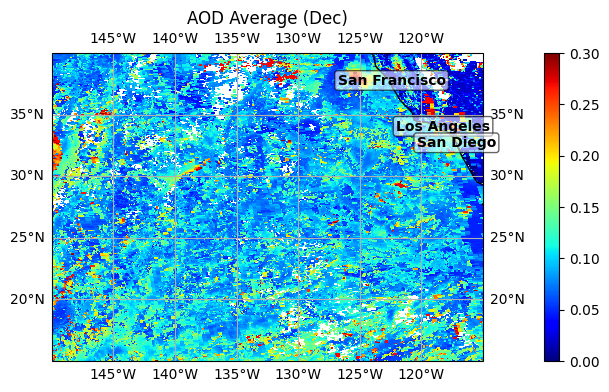

/tmp/ipykernel_146/1126569404.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


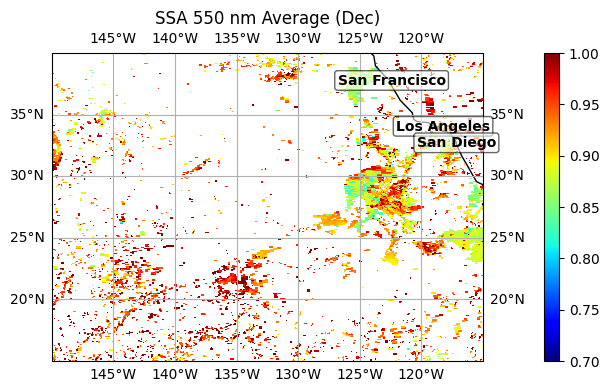

/tmp/ipykernel_146/1126569404.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


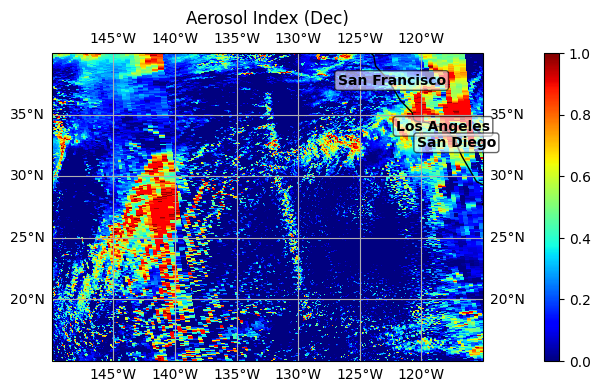

In [13]:
plot_range=[np.float32(-115),
 np.float32(-150),
 np.float32(15),
 np.float32(40)]

plot_l2_product(lons, lats,
aods, plot_range=plot_range, label='', title="AOD Average (Dec)", vmin=0, vmax=0.3, 
                 cmap="jet")

# plot_l2_product(lon, lat,
# ssa_388_dt, plot_range=plot_range, label='', title='DT_SSA', vmin=0.7, vmax=1, 
#                 fn=target_date.strftime('PACE_OCI_DTSSA_%Y%m%d.png'), cmap="jet")

plot_l2_product(lons, lats,
ssas, plot_range=plot_range, label='', title='SSA 550 nm Average (Dec)', vmin=0.7, vmax=1, 
                cmap="jet")

plot_l2_product(lons, lats,
AIs, plot_range=plot_range, label='', title='Aerosol Index (Dec)', vmin=0, vmax=1, 
                cmap="jet")
    

In [274]:
import numpy as np
import xarray as xr
from glob import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# -------------------------------
# Define target grid for bbox
# -------------------------------
lat_res = 0.1
lon_res = 0.1
lat_grid = np.arange(15, 40 + lat_res, lat_res)
lon_grid = np.arange(-150, -115 + lon_res, lon_res)
lon_target, lat_target = np.meshgrid(lon_grid, lat_grid)

# KDTree for fast nearest neighbour lookup
target_points = np.column_stack((lat_target.ravel(), lon_target.ravel()))
tree_target = cKDTree(target_points)

# -------------------------------
# Prepare storage arrays
# -------------------------------
nlat, nlon = lat_target.shape
aod_stack = []
ssa_stack = []
ai_stack = []

# -------------------------------
# Loop over each file
# -------------------------------
oci_dir = '/home/jovyan/shared-public/FirePhytos_DustBlumes/PACE_OCI_AOD/'
files = sorted(glob(oci_dir + '*202412*'))
#files = sorted(glob(oci_dir + '*202501*'))

print(f"Found {len(files)} files.")

for file in files:
    try:
        datatree = xr.open_datatree(file)
        dataset = xr.merge(datatree.to_dict().values())

        lon = np.array(dataset['longitude'])
        lat = np.array(dataset['latitude'])

        aod = np.squeeze(dataset['Aerosol_Optical_Depth'][:, :, 3].values)
        ssa = np.squeeze(dataset['NUV_AerosolSingleScattAlbedo'][:, :, 3].values)
        ai  = np.squeeze(dataset['NUV_AerosolIndex'].values)

        # Flatten
        orig_points = np.column_stack((lat.ravel(), lon.ravel()))
        aod_flat = aod.ravel()
        ssa_flat = ssa.ravel()
        ai_flat = ai.ravel()

        # Mask NaNs from AOD
        mask = ~np.isnan(aod_flat)
        orig_points = orig_points[mask]
        aod_flat = aod_flat[mask]
        ssa_flat = ssa_flat[mask]
        ai_flat = ai_flat[mask]

        # Find nearest neighbour in target grid
        _, idx_target = tree_target.query(orig_points, k=1)

        # Allocate to a grid
        aod_grid = np.full((nlat, nlon), np.nan)
        ssa_grid = np.full((nlat, nlon), np.nan)
        ai_grid  = np.full((nlat, nlon), np.nan)

        for i, idx in enumerate(idx_target):
            iy, ix = np.unravel_index(idx, (nlat, nlon))
            aod_grid[iy, ix] = aod_flat[i]
            ssa_grid[iy, ix] = ssa_flat[i]
            ai_grid[iy, ix]  = ai_flat[i]

        # Append for time averaging
        aod_stack.append(aod_grid)
        ssa_stack.append(ssa_grid)
        ai_stack.append(ai_grid)

    except Exception as e:
        print(f"Skipping file {file}: {e}")

aod_mean_dec = np.nanmean(aod_stack, axis=0)
ssa_mean_dec = np.nanmean(ssa_stack, axis=0)
ai_mean_dec  = np.nanmean(ai_stack, axis=0)


Found 226 files.


/tmp/ipykernel_113/3881754893.py:85: RuntimeWarning: Mean of empty slice
  aod_mean_dec = np.nanmean(aod_stack, axis=0)
/tmp/ipykernel_113/3881754893.py:86: RuntimeWarning: Mean of empty slice
  ssa_mean_dec = np.nanmean(ssa_stack, axis=0)
/tmp/ipykernel_113/3881754893.py:87: RuntimeWarning: Mean of empty slice
  ai_mean_dec  = np.nanmean(ai_stack, axis=0)


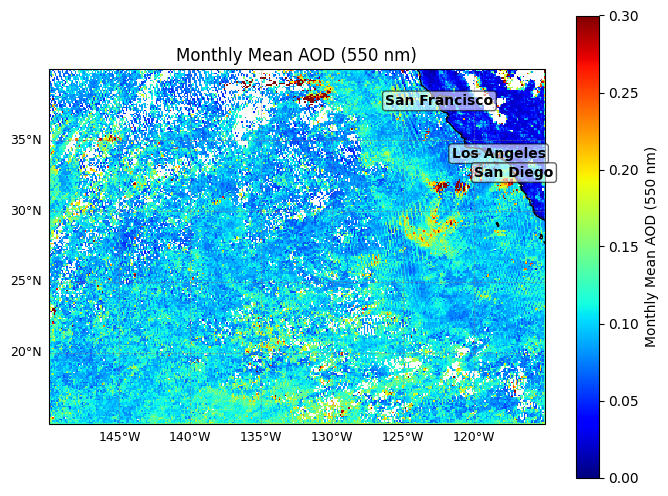

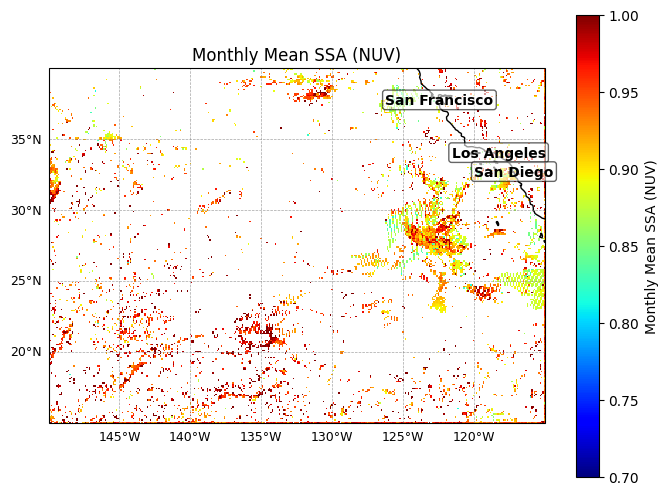

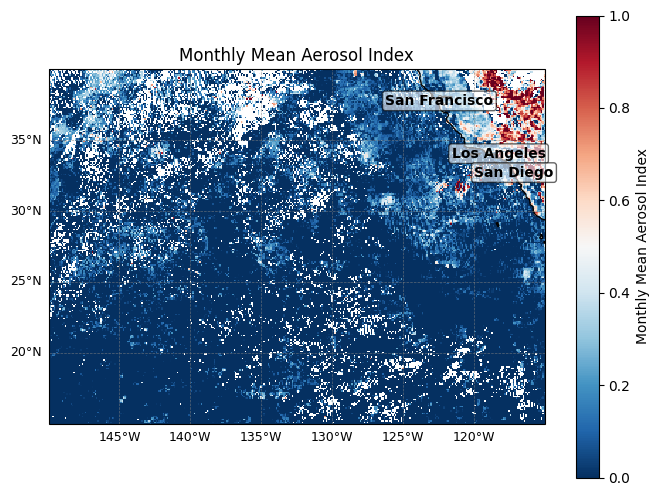

In [310]:
# -------------------------------
# Time mean
# -------------------------------

# -------------------------------
# Plotting function
# -------------------------------
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_field(data, title, vmin, vmax, cmap):
    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 6))
    
    # Plot data
    pcm = ax.pcolormesh(
        lon_target, lat_target, data,
        cmap=cmap, vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )
    
    # Coastlines & features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent([-180, -115, 15, 40], crs=ccrs.PlateCarree())
    ax.set_title(title)
    
    # Add gridlines with coordinates
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}
    
    # --- Add major city names ---
    cities = {
        "San Francisco": (-122.4194, 37.7749),
        "Los Angeles": (-118.2437, 34.0522),
        "San Diego": (-117.1611, 32.7157),
    }
    for city, (lon_c, lat_c) in cities.items():
        ax.text(lon_c, lat_c, city,
                transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold',
                color='black',
                ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2'))
    
    # Colorbar
    plt.colorbar(pcm, ax=ax, label=title)
    
    plt.show()
aod_masked = np.where(aod_mean < 0.06, np.nan, aod_mean)

# -------------------------------
# Plot results
# -------------------------------
plot_field(aod_mean_jan, "Monthly Mean AOD (550 nm)", 0, 0.3, "jet")
plot_field(ssa_mean_jan, "Monthly Mean SSA (NUV)", 0.7, 1.0, "jet")
plot_field(ai_mean_jan, "Monthly Mean Aerosol Index", 0, 1, "RdBu_r")


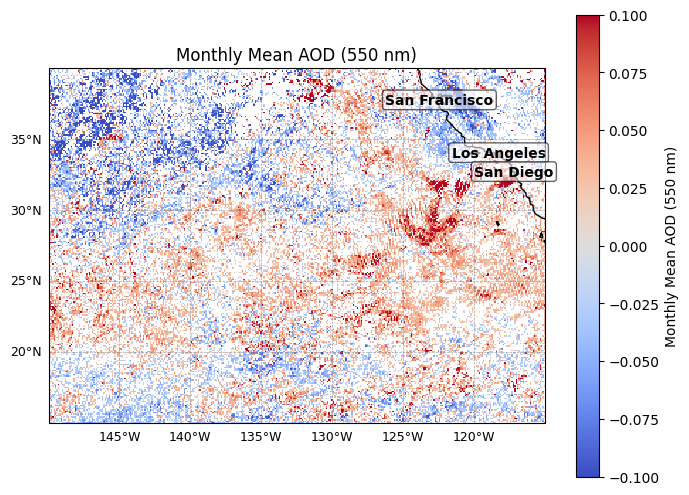

In [317]:
diff = aod_mean_jan - aod_mean_dec

# Mask values between -0.1 and 0.1
diff_masked = np.where((diff > -0.02) & (diff < 0.02), np.nan, diff)

plot_field(diff_masked, "Monthly Mean AOD (550 nm)", -0.1, 0.1, "coolwarm")
# plot_field(ssa_mean_jan-ssa_mean_dec, "Monthly Mean SSA (NUV)", -1, 1.0, "coolwarm")
# plot_field(ai_mean_jan-ai_mean_jan, "Monthly Mean Aerosol Index", -1, 1, "coolwarm")
